# Problem1

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [8]:
# Load the ratings data
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

ratings.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


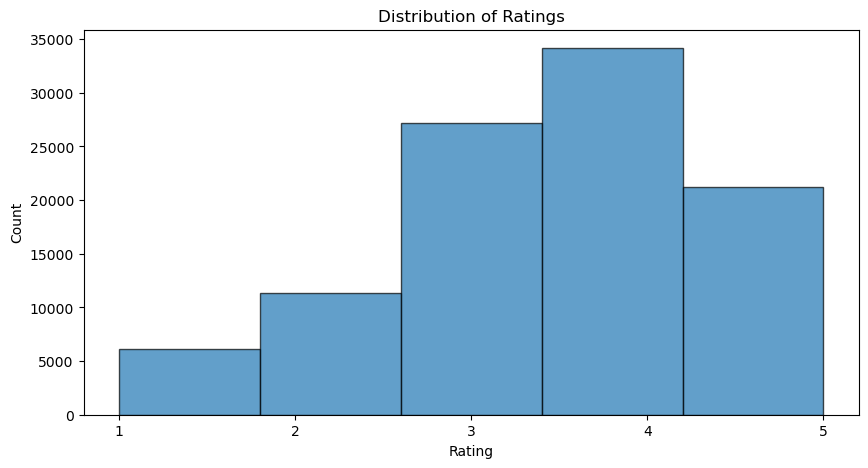

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(ratings['rating'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

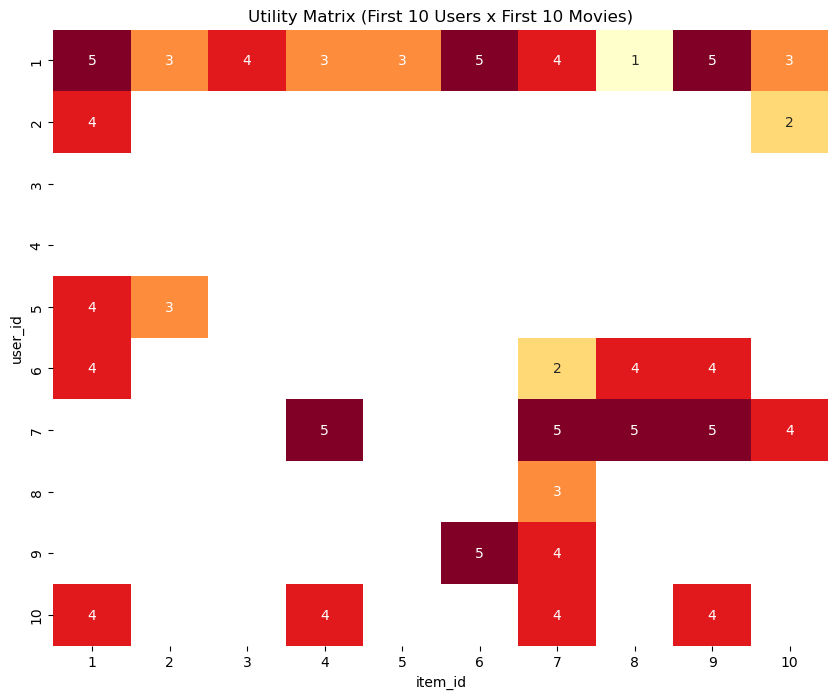

In [10]:
utility_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

plt.figure(figsize=(10, 8))
sns.heatmap(utility_matrix.iloc[:10, :10], annot=True, cmap='YlOrRd', cbar=False)
plt.title('Utility Matrix (First 10 Users x First 10 Movies)')
plt.show()

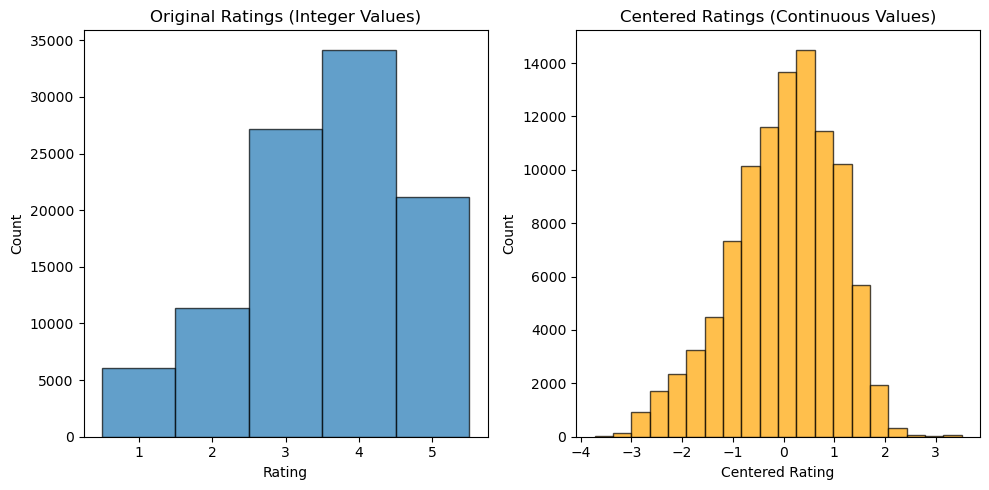

In [11]:
# Calculate user means and center the data
user_means = utility_matrix.mean(axis=1)
centered_matrix = utility_matrix.sub(user_means, axis=0)

# Get the original and centered ratings (excluding NaN values)
original_ratings = utility_matrix.values.flatten()
original_ratings = original_ratings[~np.isnan(original_ratings)]

centered_ratings = centered_matrix.values.flatten()
centered_ratings = centered_ratings[~np.isnan(centered_ratings)]

# Plot the histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(original_ratings, bins=[1, 2, 3, 4, 5, 6], edgecolor='black', align='left', alpha=0.7)
plt.title('Original Ratings (Integer Values)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([1, 2, 3, 4, 5])

plt.subplot(1, 2, 2)
plt.hist(centered_ratings, bins=20, edgecolor='black', alpha=0.7, color='orange')
plt.title('Centered Ratings (Continuous Values)')
plt.xlabel('Centered Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
# Fill NaN values with 0 for similarity calculation
centered_matrix_filled = centered_matrix.fillna(0)

# Compute cosine similarities
cosine_sim = cosine_similarity(centered_matrix_filled)

# Convert to DataFrame for easier handling
cosine_sim_df = pd.DataFrame(cosine_sim, index=utility_matrix.index, columns=utility_matrix.index)


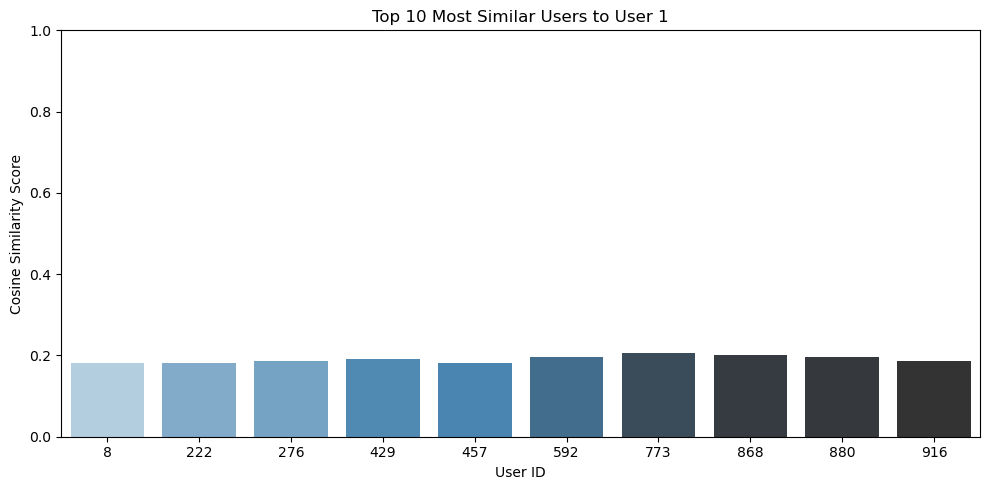

In [13]:
# Get similarities for user 1 (excluding self-similarity)
user1_similarities = cosine_sim_df.loc[1].drop(1)

# Get top 10 similar users
top10_similar_users = user1_similarities.sort_values(ascending=False).head(10).index.tolist()

user1_similarities = cosine_sim_df.loc[1].sort_values(ascending=False)[1:11]  # 排除自己

top10_df = pd.DataFrame({
    'User ID': user1_similarities.index,
    'Similarity Score': user1_similarities.values
})

plt.figure(figsize=(10, 5))
sns.barplot(
    x='User ID',
    y='Similarity Score',
    data=top10_df,
    hue='User ID',
    palette='Blues_d',
    legend=False,
    dodge=False 
)
plt.title('Top 10 Most Similar Users to User 1')
plt.ylabel('Cosine Similarity Score')
plt.ylim(0, 1)
plt.tight_layout() 
plt.show()

In [14]:
# Get ratings for item 508 from similar users (excluding any missing ratings)
item508_ratings = utility_matrix.loc[top10_similar_users, 508].dropna()

# Calculate the predicted rating as the average of similar users' ratings
if len(item508_ratings) > 0:
    predicted_rating = item508_ratings.mean()
else:
    predicted_rating = np.nan  # No similar users rated this item
print(f"The 10 most similar users to user 1 are: {top10_similar_users}")
print(f"The predicted rating for user 1 on item 508 is: {predicted_rating:.2f}")

The 10 most similar users to user 1 are: [773, 868, 592, 880, 429, 276, 916, 222, 457, 8]
The predicted rating for user 1 on item 508 is: 4.20


# Problem2

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Load the data (assuming files are extracted)
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin-1')

In [2]:
# Calculate mean rating for each user
user_mean_ratings = ratings.groupby('user_id')['rating'].mean()

# Center the ratings by subtracting each user's mean rating
ratings['centered_rating'] = ratings.apply(lambda row: row['rating'] - user_mean_ratings[row['user_id']], axis=1)

# Create user profiles (centered rating vectors)
user_profiles = ratings.pivot(index='user_id', columns='movie_id', values='centered_rating').fillna(0)

In [3]:
# Get profiles for users 15 and 200
user15_profile = user_profiles.loc[15].values.reshape(1, -1)
user200_profile = user_profiles.loc[200].values.reshape(1, -1)

# Get movie 95's ratings from all users who rated it
movie95_ratings = ratings[ratings['movie_id'] == 95]
movie95_profile = user_profiles.loc[movie95_ratings['user_id']].mean().values.reshape(1, -1)

# Calculate cosine similarity
sim15 = cosine_similarity(user15_profile, movie95_profile)[0][0]
sim200 = cosine_similarity(user200_profile, movie95_profile)[0][0]

dist15 = 1 - sim15
dist200 = 1 - sim200

In [4]:
print(f"User 15 - Cosine Similarity: {sim15:.4f}, Distance: {dist15:.4f}")
print(f"User 200 - Cosine Similarity: {sim200:.4f}, Distance: {dist200:.4f}")

if sim15 > sim200:
    print("The recommender system would suggest movie 95 to User 15")
else:
    print("The recommender system would suggest movie 95 to User 200")

User 15 - Cosine Similarity: 0.1215, Distance: 0.8785
User 200 - Cosine Similarity: 0.3647, Distance: 0.6353
The recommender system would suggest movie 95 to User 200
